In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson
import pandas as pd

### Calculate the Total Energy Stored in Resonator

In [2]:
# Define folder and file name separately
folder = r'C:\Users\user\Desktop\CU Boulder Life\博二下\McRae_Lab\Ring Resonators in a Coffin-style Microwave Package\Apr_16_Cross_Section\follow_paper'
efile = r'E_sq_halfview_0P001um'
dfile = r'D_sq_halfview_0P001um'

efile_path = os.path.join(folder, efile)
dfile_path = os.path.join(folder, dfile)


# Load data (skip header rows)
edata = np.loadtxt(efile_path, skiprows=2)
ddata = np.loadtxt(dfile_path, skiprows=2)

# Extract X, Y (assuming identical grid)
x = edata[:, 0]
y = edata[:, 1]
e2 = edata[:, 3]
d2 = ddata[:, 3]

# Compute √(|D|² / |E|²), handling zero-division safely
epsilon = np.sqrt(np.divide(d2, e2, out=np.zeros_like(d2), where=e2!=0))

# Get sorted unique x and y
x_unique = np.unique(x)
y_unique = np.unique(y)

# Build a 2D array explicitly
x_index = {val: i for i, val in enumerate(x_unique)}
y_index = {val: i for i, val in enumerate(y_unique)}

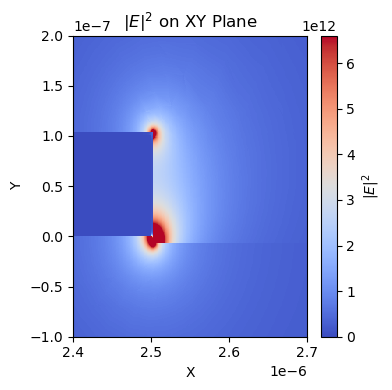

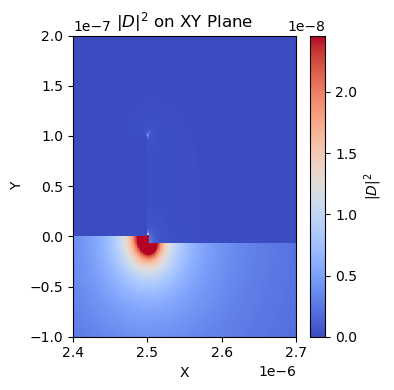

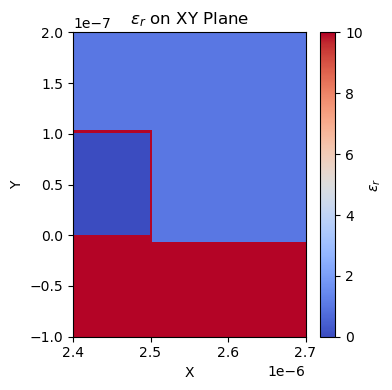

In [3]:
# Create meshgrid
X, Y = np.meshgrid(x_unique, y_unique)

####################
#### Plot |E|^2 ####
####################

# Create a mapping from (x, y) for plotting |E|²
E2 = np.full((len(y_unique), len(x_unique)), np.nan)

for xi, yi, ei in zip(x, y, e2):
    i = y_index[yi]
    j = x_index[xi]
    E2[i, j] = ei

# Clip color scale
vmin = 0
vmax = np.nanpercentile(E2, 99.999)

# Plot with 'coolwarm' colormap, where red represents stronger values and blue represents weaker values
plt.figure(figsize=(4, 4))
plt.pcolormesh(X, Y, E2, shading='auto', cmap='coolwarm', vmin=vmin, vmax=vmax)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(r'$|E|^2$ on XY Plane')
plt.colorbar(label=r'$|E|^2$')
plt.xlim([2.4E-6, 2.7E-6])
plt.ylim([-0.1E-6, 0.2E-6])
# plt.axis('equal')
plt.tight_layout()
plt.show()

####################
#### Plot |D|^2 ####
####################
# Create a mapping from (x, y) for plotting |D|²
D2 = np.full((len(y_unique), len(x_unique)), np.nan)

for xi, yi, di in zip(x, y, d2):
    i = y_index[yi]
    j = x_index[xi]
    D2[i, j] = di

# Clip color scale
vmin = 0
vmax = np.nanpercentile(D2, 99.999)

# Plot with 'coolwarm' colormap, where red represents stronger values and blue represents weaker values
plt.figure(figsize=(4, 4))
plt.pcolormesh(X, Y, D2, shading='auto', cmap='coolwarm', vmin=vmin, vmax=vmax)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(r'$|D|^2$ on XY Plane')
plt.colorbar(label=r'$|D|^2$')
plt.xlim([2.4E-6, 2.7E-6])
plt.ylim([-0.1E-6, 0.2E-6])
# plt.axis('equal')
plt.tight_layout()
plt.show()


######################
#### Plot epsilon ####
######################
# Create a 2D grid to hold the epsilon values (initialized to NaN)
epsilon_0 = 8.85E-12 # in F/m
# Calculate epsilon_r as 1D array
epsilon_r = epsilon/ epsilon_0  # make sure epsilon_values is already calculated

epsilon_r_grid = np.full((len(y_unique), len(x_unique)), np.nan)

# Map (x, y) → epsilon values
for xi, yi, eps_r_i in zip(x, y, epsilon_r):  # <- use the correct 1D array name
    i = y_index[yi]
    j = x_index[xi]
    epsilon_r_grid[i, j] = eps_r_i

# Clip color scale
vmin = 0
vmax = np.nanpercentile(epsilon_r_grid, 99.999)

# Plot
plt.figure(figsize=(4, 4))
plt.pcolormesh(X, Y, epsilon_r_grid, shading='auto', cmap='coolwarm', vmin=vmin, vmax=vmax)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(r'$\epsilon_r$ on XY Plane')
plt.colorbar(label=r'$\epsilon_r$')
plt.xlim([2.4E-6, 2.7E-6])
plt.ylim([-0.1E-6, 0.2E-6])
# plt.axis('equal')
plt.tight_layout()
plt.show()

Total electric energy (U) = 6.6418e-11 J


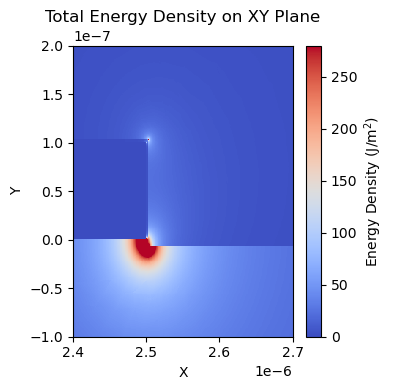

In [4]:
####################################
#### Calculate the Total Energy ####
####################################
# Assume E2_grid and epsilon_grid have shape (len(y_unique), len(x_unique))
# and are aligned with the meshgrid X, Y

# Compute |E|^2 * ε point-wise
energy_density = E2 * epsilon_r_grid * epsilon_0  # shape = (Ny, Nx)

# Calculate grid spacing (assumes uniform grid)
dx = np.mean(np.diff(x_unique))
dy = np.mean(np.diff(y_unique))

# Integrate over x and y
total_energy = np.nansum(energy_density) * dx * dy

print(f"Total electric energy (U) = {total_energy:.4e} J")


###################################
#### Plot total energy density ####
###################################
# Clip color scale
vmin = 0
vmax = np.nanpercentile(energy_density, 99.999)

# Plot
plt.figure(figsize=(4, 4))
plt.pcolormesh(X, Y, energy_density, shading='auto', cmap='coolwarm', vmin=vmin, vmax=vmax)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(r'Total Energy Density on XY Plane')
plt.colorbar(label=r'Energy Density (J/m$^2$)')
plt.xlim([2.4E-6, 2.7E-6])
plt.ylim([-0.1E-6, 0.2E-6])
# plt.axis('equal')
plt.tight_layout()
plt.show()

### Calculate the E-field at Interface

In [5]:
def integrate_E2(X, Y, E2, x_min, x_max, y_min, y_max, permittivity=10):
    # Mask the region of interest
    mask = (X >= x_min) & (X <= x_max) & (Y >= y_min) & (Y <= y_max)
    
    # Get the dA (area of each cell). Assuming uniform grid:
    dx = np.mean(np.diff(np.unique(X)))
    dy = np.mean(np.diff(np.unique(Y)))
    dA = dx * dy

    # Integrate E2 over the selected region
    integral = np.sum(E2[mask]) * dA
    
    # Multiply by permittivity
    result = integral * permittivity

    return result

In [23]:
###############################################
#### Determine the region of the interface ####
###############################################
# interface : [xmin, xmax, ymin, ymax]
# MA_res_top: [0, 2.5e-6, 0.1e-6, 0.103e-6]
# C_res_top: [2.5e-6, 2.503e-6, 0.1e-6, 0.103e-6]
# MA_res_right: [2.5e-6, 2.503e-6, 0.0015e-6, 0.1e-6]
# C_res_middle: [2.5e-6, 2.503e-6, -0.0015e-6, 0.0015e-6]
# SA_res_right: [2.5e-6, 2.503e-6, -0.007e-6, -0.0015e-6]
# SA_bottom: [2.503e-6, 4.497e-6, -0.007e-6, -0.004e-6]
# SA_ground_left: [4.497e-6, 4.5e-6, -0.007e-6, -0.0015e-6]
# C_ground_middle: [4.497e-6, 4.5e-6, -0.0015e-6, 0.0015e-6]
# MA_ground_left: [4.497e-6, 4.5e-6, 0.0015e-6, 0.1e-6]
# C_ground_top: [4.497e-6, 4.5e-6, 0.1e-6, 0.103e-6]
# MA_ground_top: [4.5e-6, 7e-6, 0.1e-6, 0.103e-6]
# MS_res: [0, 2.5e-6, -0.003e-6, 0]
# MS_ground: [4.5e-6, 7e-6, -0.003e-6, 0]

bound = [4.5e-6, 7e-6, -0.003e-6, 0]
x_min, x_max, y_min, y_max = bound

regional_energy = integrate_E2(x, y, e2, x_min, x_max, y_min, y_max, permittivity=10 * epsilon_0)
print(f"Integrated |E|^2 * permittivity = {regional_energy:.4e} J/m")

#############################
#### participation ratio ####
#############################
participation_ratio = regional_energy / total_energy
print(f"Participation Ratio = {int(participation_ratio * 1E6)} ppm")

Integrated |E|^2 * permittivity = 8.7509e-14 J/m
Participation Ratio = 1317 ppm
